In [ ]:
!nvidia-smi

Fri Jun 23 12:59:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Stuff

In [ ]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def plot_images(img_path_a, img_path_b, model, output_path):
     # Open the images
    image_a = Image.open(img_path_a)
    image_b = Image.open(img_path_b)

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2)

    # Display image A
    axs[0].imshow(image_a)
    axs[0].axis('off')

    # Display image B
    axs[1].imshow(image_b)
    axs[1].axis('off')

    # Set the title and attributes for image A
    title_a = f"JPEG compression {model} 4X"
    attributes_text_a = f"{Path(img_path_a).stem}\n"

    # Set the title and attributes for image B
    title_b = f"Bicubic scaling {model} 4X"
    attributes_text_b = f"{Path(img_path_b).stem}\n"

    # Add the titles and attributes as text below the images
    axs[0].set_title(f"{title_a}\n{attributes_text_a}")
    axs[1].set_title(f"{title_b}\n{attributes_text_b}")

    # Adjust the layout and display the plot
    plt.tight_layout()
    # plt.draw()

    plt.savefig(os.path.join(output_path,
                             f"plot_{Path(img_path_a).stem}_{Path(img_path_b).stem}.png"),
                dpi=200,bbox_inches='tight')
    # plt.show()

# SRGAN

https://github.com/Lornatang/SRGAN-PyTorch

## Setup

In [ ]:
!git clone https://github.com/Lornatang/SRGAN-PyTorch.git

Cloning into 'SRGAN-PyTorch'...
remote: Enumerating objects: 3417, done.
remote: Counting objects: 100% (693/693), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 3417 (delta 537), reused 616 (delta 489), pack-reused 2724
Receiving objects: 100% (3417/3417), 2.94 MiB | 6.64 MiB/s, done.
Resolving deltas: 100% (2245/2245), done.


In [ ]:
%cd /content/SRGAN-PyTorch

/content/SRGAN-PyTorch


In [ ]:
!gdown 1syo53sxN7titVu8iMQUZKMlhol1aw9Oe

Downloading...
From: https://drive.google.com/uc?id=1syo53sxN7titVu8iMQUZKMlhol1aw9Oe
To: /content/SRGAN-PyTorch/SRGAN_x4-ImageNet-8c4a7569.pth.tar
100% 6.29M/6.29M [00:00<00:00, 18.9MB/s]


In [ ]:
model = "/content/SRGAN-PyTorch/SRGAN_x4-ImageNet-8c4a7569.pth.tar"

In [ ]:
!pip install -r requirements.txt

In [ ]:
!mkdir test_folder
!mkdir output_folder

In [ ]:
## Prepare

In [ ]:
import os
from pathlib import Path

import cv2
import torch
from torch import nn

import model
from imgproc import preprocess_one_image, tensor_to_image, image_to_tensor
from utils import load_pretrained_state_dict

def preprocess_one_image(image_path: str, range_norm: bool, half: bool, device: torch.device):
    # read an image using OpenCV
    image = cv2.imread(image_path).astype(np.float32) / 255.0

    # BGR image channel data to RGB image channel data
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert RGB image channel data to image formats supported by PyTorch
    tensor = image_to_tensor(image, range_norm, half).unsqueeze_(0)

    # Data transfer to the specified device
    tensor = tensor.to(device, non_blocking=True)

    return tensor

def build_model(model_arch_name: str, device: torch.device) -> nn.Module:
    # Initialize the super-resolution model
    sr_model = model.__dict__[model_arch_name](in_channels=3,
                                               out_channels=3,
                                               channels=64,
                                               num_rcb=16)

    sr_model = sr_model.to(device)

    return sr_model

In [ ]:
def inference():
  with torch.no_grad():
    for image_path in image_paths:
      try:
        image_path = "/content/SRGAN-PyTorch/test_folder/" + image_path
        print(image_path)
        input_tensor = preprocess_one_image(image_path, False, False, device)
        sr_tensor = sr_model(input_tensor)
        # Save image
        cr_image = tensor_to_image(sr_tensor, False, False)
        cr_image = cv2.cvtColor(cr_image, cv2.COLOR_RGB2BGR)
        if "jpeg" in image_path:
          cr_image = cv2.resize(cr_image,(0,0),fx = 0.25,fy = 0.25, interpolation=cv2.INTER_CUBIC)
        elif "bicubic" in image_path:
          cr_image = cv2.resize(cr_image, (target_width, target_height), interpolation=cv2.INTER_CUBIC)
        sr_path = f"/content/SRGAN-PyTorch/output_folder/srgan_{Path(image_path).stem}.png"
        cv2.imwrite(sr_path, cr_image)
        print(f"SR image save to `{sr_path}`")
      except:
        pass

In [ ]:
device = torch.device("cuda:0")
model_weights_path = "/content/SRGAN-PyTorch/SRGAN_x4-ImageNet-8c4a7569.pth.tar"

# Initialize the model
sr_model = build_model("srresnet_x4", device)
print(f"Build srresnet_x4 model successfully.")

# Load model weights
sr_model = load_pretrained_state_dict(sr_model, False, model_weights_path)
print(f"Load srresnet_x4 model weights `{os.path.abspath(model_weights_path)}` successfully.")

# Start the verification mode of the model.
sr_model.eval()

## Inference

In [ ]:
image_paths = os.listdir("test_folder")
target_width = 505
target_height = 328

inference()

## Plotting

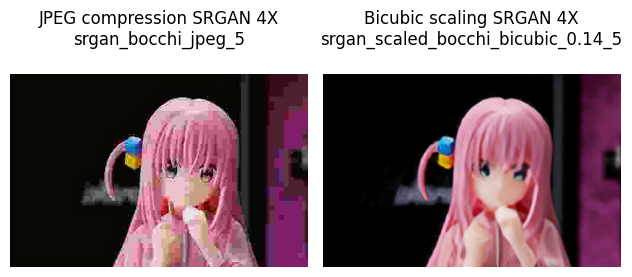

In [ ]:
plot_images("/content/SRGAN-PyTorch/output_folder/srgan_bocchi_jpeg_5.png",
            "/content/SRGAN-PyTorch/output_folder/srgan_scaled_bocchi_bicubic_0.14_5.png",
            "SRGAN", "/content/SRGAN-PyTorch/output_folder")

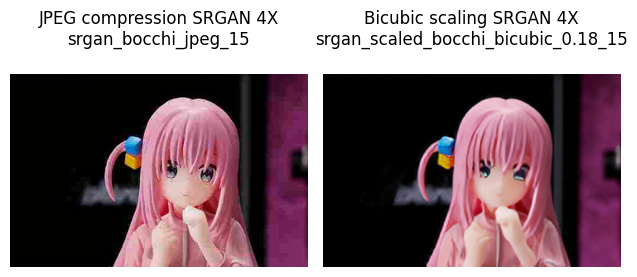

In [ ]:
plot_images("/content/SRGAN-PyTorch/output_folder/srgan_bocchi_jpeg_15.png",
            "/content/SRGAN-PyTorch/output_folder/srgan_scaled_bocchi_bicubic_0.18_15.png",
            "SRGAN", "/content/SRGAN-PyTorch/output_folder")

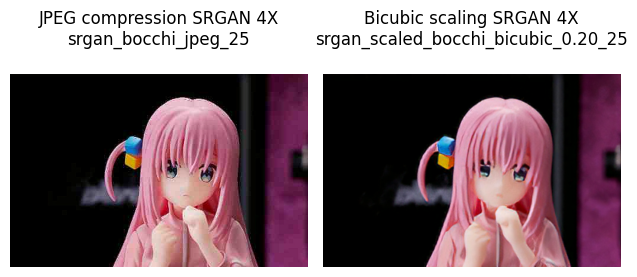

In [ ]:
plot_images("/content/SRGAN-PyTorch/output_folder/srgan_bocchi_jpeg_25.png",
            "/content/SRGAN-PyTorch/output_folder/srgan_scaled_bocchi_bicubic_0.20_25.png",
            "SRGAN", "/content/SRGAN-PyTorch/output_folder")

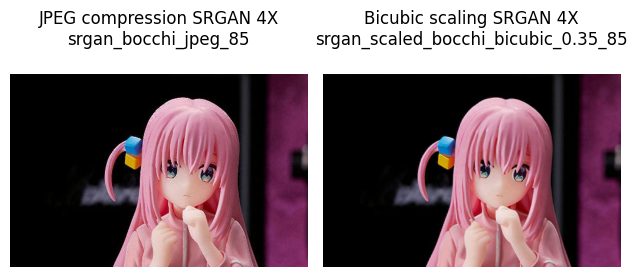

In [ ]:
plot_images("/content/SRGAN-PyTorch/output_folder/srgan_bocchi_jpeg_85.png",
            "/content/SRGAN-PyTorch/output_folder/srgan_scaled_bocchi_bicubic_0.35_85.png",
            "SRGAN", "/content/SRGAN-PyTorch/output_folder")

# ESRGAN

## Setup

In [ ]:
!git clone https://github.com/xinntao/ESRGAN
%cd ESRGAN

Cloning into 'ESRGAN'...
remote: Enumerating objects: 225, done.
remote: Total 225 (delta 0), reused 0 (delta 0), pack-reused 225
Receiving objects: 100% (225/225), 24.86 MiB | 38.39 MiB/s, done.
Resolving deltas: 100% (86/86), done.
/content/ESRGAN
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
!gdown 1TPrz5QKd8DHHt1k8SRtm6tMiPjz_Qene

Downloading...
From: https://drive.google.com/uc?id=1TPrz5QKd8DHHt1k8SRtm6tMiPjz_Qene
To: /content/ESRGAN/RRDB_ESRGAN_x4.pth
100% 66.9M/66.9M [00:00<00:00, 106MB/s]


In [ ]:
!mkdir test_folder
!mkdir output_folder

## Prepare

In [ ]:
import os.path as osp
import glob
import cv2
import numpy as np
import torch
import RRDBNet_arch as arch
import os
from pathlib import Path

In [ ]:
model_path = '/content/ESRGAN/RRDB_ESRGAN_x4.pth'  # models/RRDB_ESRGAN_x4.pth OR models/RRDB_PSNR_x4.pth
device = torch.device('cuda')  # if you want to run on CPU, change 'cuda' -> cpu

In [ ]:
test_img_folder = '/content/ESRGAN/test_folder/'

In [ ]:
model = arch.RRDBNet(3, 3, 64, 23, gc=32)
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
model = model.to(device)
print('Model path {:s}. \nTesting...'.format(model_path))

Model path /content/ESRGAN/RRDB_ESRGAN_x4.pth. 
Testing...


In [ ]:
def inference():
  with torch.no_grad():
    for image_path in image_paths:
      image_path = "/content/ESRGAN/test_folder/" + image_path
      print(image_path)
      img = cv2.imread(image_path, cv2.IMREAD_COLOR)
      img = img * 1.0 / 255

      img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float()
      img_LR = img.unsqueeze(0)
      img_LR = img_LR.to(device)
      output = model(img_LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
      output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
      output = (output * 255.0).round()

      if "jpeg" in image_path:
        cr_image = cv2.resize(output,(0,0),fx = 0.25,fy = 0.25, interpolation=cv2.INTER_CUBIC)
      elif "bicubic" in image_path:
        cr_image = cv2.resize(output, (target_width, target_height), interpolation=cv2.INTER_CUBIC)
      sr_path = f"/content/ESRGAN/output_folder/esrgan_{Path(image_path).stem}.png"
      cv2.imwrite(sr_path, cr_image)
      print(f"ESR image save to `{sr_path}`")

## Inference

In [ ]:
image_paths = os.listdir("test_folder")
target_width = 505
target_height = 328

inference()

/content/ESRGAN/test_folder/scaled_bocchi_bicubic_0.14_5.png
ESR image save to `/content/ESRGAN/output_folder/esrgan_scaled_bocchi_bicubic_0.14_5.png`
/content/ESRGAN/test_folder/scaled_bocchi_bicubic_0.18_15.png
ESR image save to `/content/ESRGAN/output_folder/esrgan_scaled_bocchi_bicubic_0.18_15.png`
/content/ESRGAN/test_folder/scaled_bocchi_bicubic_0.20_25.png
ESR image save to `/content/ESRGAN/output_folder/esrgan_scaled_bocchi_bicubic_0.20_25.png`
/content/ESRGAN/test_folder/bocchi_jpeg_15.jpg
ESR image save to `/content/ESRGAN/output_folder/esrgan_bocchi_jpeg_15.png`
/content/ESRGAN/test_folder/scaled_bocchi_bicubic_0.35_85.png
ESR image save to `/content/ESRGAN/output_folder/esrgan_scaled_bocchi_bicubic_0.35_85.png`
/content/ESRGAN/test_folder/bocchi_jpeg_85.jpg
ESR image save to `/content/ESRGAN/output_folder/esrgan_bocchi_jpeg_85.png`
/content/ESRGAN/test_folder/bocchi_jpeg_5.jpg
ESR image save to `/content/ESRGAN/output_folder/esrgan_bocchi_jpeg_5.png`
/content/ESRGAN/test_fo

## Plotting

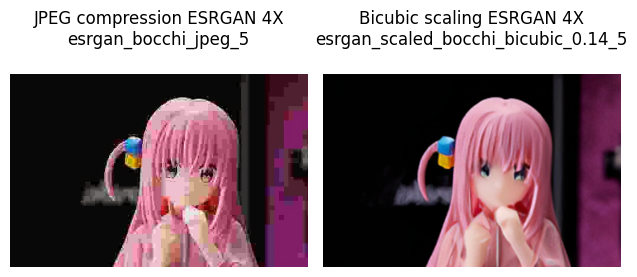

In [ ]:
plot_images("/content/ESRGAN/output_folder/esrgan_bocchi_jpeg_5.png",
            "/content/ESRGAN/output_folder/esrgan_scaled_bocchi_bicubic_0.14_5.png",
            "ESRGAN", "/content/ESRGAN/output_folder")

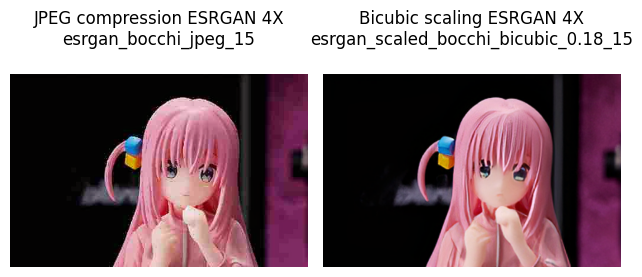

In [ ]:
plot_images("/content/ESRGAN/output_folder/esrgan_bocchi_jpeg_15.png",
            "/content/ESRGAN/output_folder/esrgan_scaled_bocchi_bicubic_0.18_15.png",
            "ESRGAN", "/content/ESRGAN/output_folder")

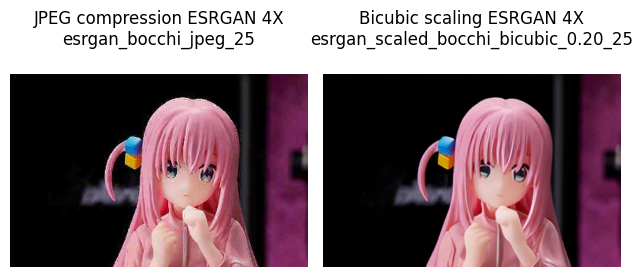

In [ ]:
plot_images("/content/ESRGAN/output_folder/esrgan_bocchi_jpeg_25.png",
            "/content/ESRGAN/output_folder/esrgan_scaled_bocchi_bicubic_0.20_25.png",
            "ESRGAN", "/content/ESRGAN/output_folder")

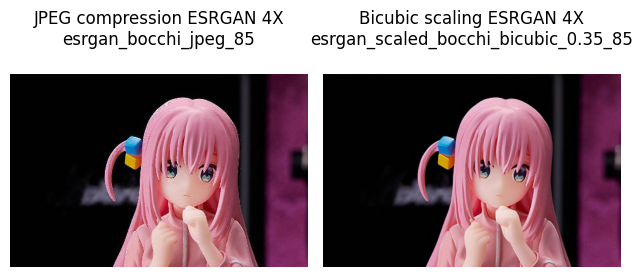

In [ ]:
plot_images("/content/ESRGAN/output_folder/esrgan_bocchi_jpeg_85.png",
            "/content/ESRGAN/output_folder/esrgan_scaled_bocchi_bicubic_0.35_85.png",
            "ESRGAN", "/content/ESRGAN/output_folder")

# Real-ESRGAN

## Setup

In [ ]:
!git clone https://github.com/xinntao/Real-ESRGAN

Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 755, done.
remote: Total 755 (delta 0), reused 0 (delta 0), pack-reused 755
Receiving objects: 100% (755/755), 5.37 MiB | 23.48 MiB/s, done.
Resolving deltas: 100% (410/410), done.


In [ ]:
%cd Real-ESRGAN

/content/Real-ESRGAN


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214823 sha256=6923986587c688218904e72d9985ba613622b703509fbfaa318a1bdfabba9be3
  Stored in directory: /root/.cache/pip/wheels/38/83/99/2d8437cc652a01af27df5ff037a4075e95b52d67705c5f3

In [ ]:
!mkdir test_folder
!mkdir output_folder

In [ ]:
!python setup.py develop

/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://github.com/pypa/setuptools/issues/917 for details.
 

## Prepare

In [ ]:
from pathlib import Path
import os
import cv2

def post_process():
  for image_path in image_paths:
    tmp = image_path.split(".")
    image_out_path = Path(image_path).stem + "_out." + tmp[-1]
    print("/content/Real-ESRGAN/output_folder/" + image_out_path)
    img = cv2.imread("/content/Real-ESRGAN/output_folder/" + image_out_path, cv2.IMREAD_COLOR)
    if "jpeg" in image_path:
      img = cv2.resize(img,(0,0),fx = 0.25,fy = 0.25, interpolation=cv2.INTER_CUBIC)
    elif "bicubic" in image_path:
      img = cv2.resize(img, (target_width, target_height), interpolation=cv2.INTER_CUBIC)
    sr_path = f"/content/Real-ESRGAN/output_folder/real_esrgan_{Path(image_path).stem}.png"
    cv2.imwrite(sr_path, img)
    print(f"Real-ESR image save to `{sr_path}`")

## Inference

In [ ]:
!python inference_realesrgan.py -n RealESRGAN_x4plus -i "/content/Real-ESRGAN/test_folder" --output "/content/Real-ESRGAN/output_folder"

image_paths = os.listdir("test_folder")
target_width = 505
target_height = 328
post_process()

## Plotting

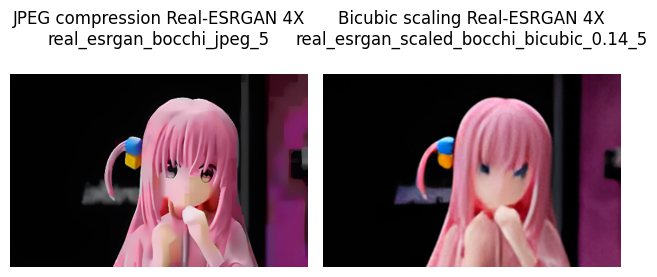

In [ ]:
plot_images("/content/Real-ESRGAN/output_folder/real_esrgan_bocchi_jpeg_5.png",
            "/content/Real-ESRGAN/output_folder/real_esrgan_scaled_bocchi_bicubic_0.14_5.png",
            "Real-ESRGAN", "/content/Real-ESRGAN/output_folder")

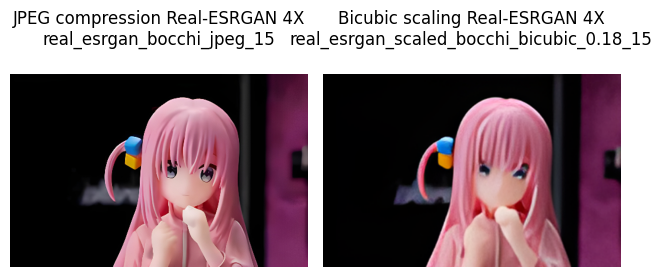

In [ ]:
plot_images("/content/Real-ESRGAN/output_folder/real_esrgan_bocchi_jpeg_15.png",
            "/content/Real-ESRGAN/output_folder/real_esrgan_scaled_bocchi_bicubic_0.18_15.png",
            "Real-ESRGAN", "/content/Real-ESRGAN/output_folder")

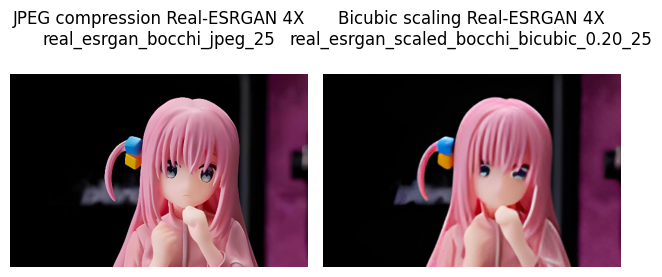

In [ ]:
plot_images("/content/Real-ESRGAN/output_folder/real_esrgan_bocchi_jpeg_25.png",
            "/content/Real-ESRGAN/output_folder/real_esrgan_scaled_bocchi_bicubic_0.20_25.png",
            "Real-ESRGAN", "/content/Real-ESRGAN/output_folder")

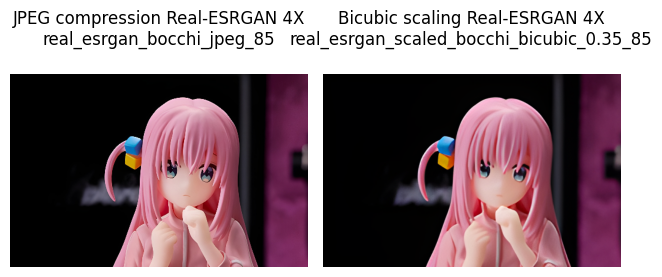

In [ ]:
plot_images("/content/Real-ESRGAN/output_folder/real_esrgan_bocchi_jpeg_85.png",
            "/content/Real-ESRGAN/output_folder/real_esrgan_scaled_bocchi_bicubic_0.35_85.png",
            "Real-ESRGAN", "/content/Real-ESRGAN/output_folder")